# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob

In [20]:
DATA_DIR = "../data"
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")

## Leaf Mappings

There are multiple images per leaf, taken from different angles. The CSVs map the image filenames to a leaf.

In [4]:
import pandas as pd

In [5]:
LEAF_MAPS_DIR = os.path.join(RAW_DATA_DIR, "leaf_grouping", "leaf_maps")
FILTERED_LEAF_MAPS_DIR = os.path.join(RAW_DATA_DIR, "leaf_grouping", "filtered_leafmaps")

In [6]:
def csv_summary(df):
    print(f"num_rows: {df.shape[0]}, num_columns: {df.shape[1]}")
    print(f"columns: {list(df.columns)}")
    return df.head()
    
def load_csv(base_dir, filename):
    df = pd.read_csv(os.path.join(base_dir, filename), engine="python")
    return df

In [7]:
apple_scab_df = load_csv(LEAF_MAPS_DIR, "Apple_Scab.csv")
csv_summary(apple_scab_df)

num_rows: 630, num_columns: 2
columns: ['File Name', 'Leaf #']


,File Name,Leaf #
0,FREC_Scab 2907.JPG,1.0
1,FREC_Scab 2908.JPG,1.0
2,FREC_Scab 2909.JPG,1.0
3,FREC_Scab 2910.JPG,1.0
4,FREC_Scab 2911.JPG,1.0


In [8]:
strawberry_scorch_df = load_csv(LEAF_MAPS_DIR, "Strawberry_Scorch.csv")
csv_summary(strawberry_scorch_df)

num_rows: 776, num_columns: 2
columns: ['File Name', 'Leaf #']


,File Name,Leaf #
0,RS_L.Scorch 0844.JPG,1.0
1,RS_L.Scorch 0845.JPG,1.0
2,RS_L.Scorch 0846.JPG,1.0
3,RS_L.Scorch 0847.JPG,1.0
4,RS_L.Scorch 0848.JPG,1.0


In [9]:
load_csv(LEAF_MAPS_DIR, "Raspberry_Sheet1.csv")

,File Name,Leaf #
0,Mary_HL 6214.JPG,1.0
1,Mary_HL 6215.JPG,1.0
2,Mary_HL 6216.JPG,1.0
3,Mary_HL 6217.JPG,1.0
4,Mary_HL 6218.JPG,1.0
...,...,...
366,Mary_HL 9351.JPG,37.0
367,Mary_HL 9352.JPG,37.0
368,Mary_HL 9353.JPG,37.0
369,Mary_HL 9354.JPG,37.0


In [10]:
load_csv(FILTERED_LEAF_MAPS_DIR, "Apple___Apple_scab.csv")

,File Name,Leaf #
0,FREC_Scab 2907.JPG,1.0
1,FREC_Scab 2908.JPG,1.0
2,FREC_Scab 2909.JPG,1.0
3,FREC_Scab 2910.JPG,1.0
4,FREC_Scab 2911.JPG,1.0
...,...,...
625,FREC_Scab 3533.JPG,108.0
626,FREC_Scab 3534.JPG,108.0
627,FREC_Scab 3535.JPG,108.0
628,FREC_Scab 3536.JPG,108.0


## Images

In [61]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from IPython.core.display import display

%matplotlib inline

### PIL

https://pillow.readthedocs.io/en/stable/handbook/tutorial.html#processing-individual-bands


In [62]:
RAW_IMAGES_DIR = os.path.join(RAW_DATA_DIR, "raw")
COLOR_IMAGES_DIR = os.path.join(RAW_IMAGES_DIR, "color")

In [63]:
apple_scab_filenames = glob.glob(os.path.join(COLOR_IMAGES_DIR, "Apple___Apple_scab", "*.JPG"))

In [64]:
im = Image.open(apple_scab_filenames[0])

In [65]:
print(im.format, im.size, im.mode)

JPEG (256, 256) RGB


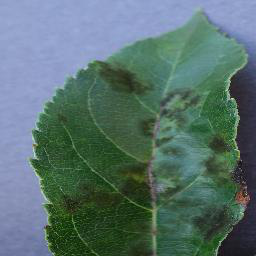

In [66]:
im

In [67]:
# split the image into individual bands
R, G, B = 0, 1, 2
source = im.split()

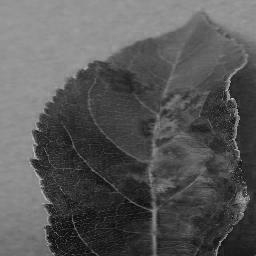

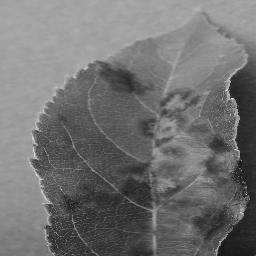

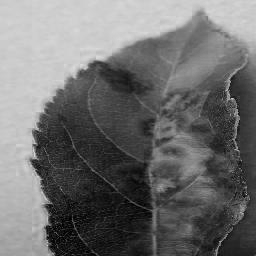

In [69]:
for i in range(3):
    display(source[i])

In [70]:
# select regions where red is less than 100
mask = source[R].point(lambda i: i < 100 and 255)

In [71]:
# process the green band
out = source[G].point(lambda i: i * 0.7)

In [72]:
# paste the processed band back, but only where red was < 100
source[G].paste(out, None, mask)

In [73]:
# build a new multiband image
im2 = Image.merge(im.mode, source)

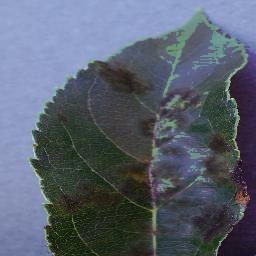

In [74]:
display(im2)